In [1]:
import torch
import numpy as np
from PIL import Image   # 图像处理模块
from matplotlib import pyplot as plt
import os   # 导入os库，用于处理文件和目录路径
from torch.utils.data import Dataset,DataLoader   # 导入DataSet类，用于自定义数据集类型

In [2]:
# 自定义数据集类型，元素（noise_img_tensor, original_img_tensor）
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.main_dir = image_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)    # 获取目录下所有图片文件名
    
    def __len__(self):
        return len(self.image_names)
    
    # 传入图片id，获取数据集元素 （x, y）
    def __getitem__(self, idx):
        # 1. 根据索引号，构建图片的完整路径
        image_loc = os.path.join(self.main_dir, self.image_names[idx])
        # 2. 使用 PIL 打开图片
        image = Image.open(image_loc).convert('RGB')
        # 3. 利用transform转换成tensor
        if self.transform is not None:
            tensor_img = self.transform(image)
        else:
            # 如果为None，就抛出异常
            raise ValueError("transform 参数不能为 None！")
        # 4. 向原始图像中增加噪声
        noise_factor = 0.5
        noise_img = tensor_img + noise_factor * torch.randn_like(tensor_img)
        noise_img = torch.clamp(noise_img, 0., 1.)
        
        # 返回 (噪声图片，原始图片)
        return noise_img, tensor_img

In [3]:
import torchvision.transforms as T  # 图像预处理模块

# 测试主流程
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.Resize((68, 68)),
    T.ToTensor()
])

# 1. 创建数据集
full_dataset = ImageDataset(image_dir='/root/datasets/imagedata/dataset', transform=transform)
print(len(full_dataset))

24853


In [4]:
from torch.utils.data import random_split 
# 2. 划分数据集
train_dataset, test_dataset = random_split(full_dataset, [0.75, 0.25])
print(len(train_dataset))
print(len(test_dataset))

18640
6213


In [5]:
# 3. 创建DataLoader
batch_size = 32
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True
)

In [6]:
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [7]:
for x, y in train_loader:
    print(f'x: {x}, x shape: {x.shape}, x device: {x.device}')
    print(f'y: {y}, y shape: {y.shape}, y device: {y.device}')
    break

x: tensor([[[[1.0000, 0.5852, 0.1947,  ..., 0.3886, 0.9795, 0.9753],
          [0.0952, 0.6788, 1.0000,  ..., 1.0000, 0.7412, 1.0000],
          [0.5268, 1.0000, 1.0000,  ..., 0.4461, 1.0000, 1.0000],
          ...,
          [0.5880, 1.0000, 0.0000,  ..., 0.7071, 0.6418, 1.0000],
          [0.5347, 1.0000, 0.6604,  ..., 1.0000, 0.9312, 0.1048],
          [0.8858, 1.0000, 0.4929,  ..., 0.8707, 0.6409, 0.5055]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.2817, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.6415, 1.0000],
          [1.0000, 0.9447, 1.0000,  ..., 1.0000, 0.8195, 0.5225],
          ...,
          [1.0000, 0.5880, 1.0000,  ..., 0.9104, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9423, 0.6746],
          [0.6683, 0.4456, 1.0000,  ..., 0.9617, 0.8184, 1.0000]],

         [[0.0872, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.4665],
          [0.7838, 1.0000, 1.0000,  ..., 0.4421, 0.1923, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...

In [8]:
import torch.nn as nn
# 定义神经网络结构类
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        # 编码器
        # 三个卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        # 通用池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 解码器
        # 三个转置卷积层
        self.t_conv1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        # 普通卷积层
        self.conv_out = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        # 编码
        x = torch.relu(self.conv1(x))
        # print("Conv1 output shape: ", x.shape)
        x = self.pool(x)
        # print("Pool1 output shape: ", x.shape)
        x = torch.relu(self.conv2(x))
        # print("Conv2 output shape: ", x.shape)
        x = self.pool(x)
        # print("Pool2 output shape: ", x.shape)
        x = torch.relu(self.conv3(x))
        # print("Conv3 output shape: ", x.shape)
        x = self.pool(x)
        # print("Pool3 output shape: ", x.shape)
        # 解码
        x = torch.relu(self.t_conv1(x))
        # print("T_Conv1 output shape: ", x.shape)
        x = torch.relu(self.t_conv2(x))
        # print("T_Conv2 output shape: ", x.shape)
        x = torch.relu(self.t_conv3(x))
        # print("T_Conv3 output shape: ", x.shape)
        x = torch.sigmoid(self.conv_out(x))
        # print("Conv output shape: ", x.shape)
        return x

In [9]:
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [10]:
# 随便输入一个数据进行前向传播测试
x = torch.randn(1, 3, 68, 68)
y = model(x)
print(y.shape)

torch.Size([1, 3, 68, 68])


In [11]:
# 定义损失函数和优化器
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 训练
num_epochs = 10

model.to(device)

for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    for noise_imgs, tensor_imgs in train_loader:
        # 0. 将数据移动到设备上
        noise_imgs = noise_imgs.to(device)
        tensor_imgs = tensor_imgs.to(device)
        # 1. 前向传播
        outputs = model(noise_imgs)
        # 2. 计算损失
        loss_value = loss(outputs, tensor_imgs)
        # 3. 反向传播
        loss_value.backward()
        # 4. 更新参数
        optimizer.step()
        # 5. 清除梯度
        optimizer.zero_grad()
        # 6. 累计损失
        train_loss += loss_value.item()
    # 本轮训练结束，计算平均损失
    this_loss = train_loss / len(train_loader)
    print(f'epoch: {epoch}, train_loss: {this_loss:.6f}')

epoch: 1, train_loss: 0.039233
epoch: 2, train_loss: 0.014226
epoch: 3, train_loss: 0.012392
epoch: 4, train_loss: 0.011678
epoch: 5, train_loss: 0.011323
epoch: 6, train_loss: 0.011079
epoch: 7, train_loss: 0.010842
epoch: 8, train_loss: 0.010652
epoch: 9, train_loss: 0.010488
epoch: 10, train_loss: 0.010356


In [13]:
# 验证模型效果
# 从测试数据加载器获取一个批次的测试图像数据
loader_iter = iter(test_loader)
noise_imgs, original_imgs = next(loader_iter)
print(noise_imgs.shape)
print(original_imgs.shape)

torch.Size([32, 3, 68, 68])
torch.Size([32, 3, 68, 68])


In [14]:
# 开始测试
model = model.to(device)
noise_imgs = noise_imgs.to(device)

outputs = model(noise_imgs)     # 前向传播

print(outputs.shape)

torch.Size([32, 3, 68, 68])


In [15]:
# 变换数据，准备画图
# 1. 噪声图像
noise_imgs = noise_imgs.permute(0, 2, 3, 1).cpu().numpy()
print("转换后的噪声图像形状：", noise_imgs.shape)

转换后的噪声图像形状： (32, 68, 68, 3)


In [16]:
# 2. 去噪图像
outputs = outputs.permute(0, 2, 3, 1).detach().cpu().numpy()
print("转换后的去噪图像形状：", outputs.shape)
# 3. 原始图像
original_imgs = original_imgs.permute(0, 2, 3, 1).cpu().numpy()
print("转换后的原始图像形状：", original_imgs.shape)

转换后的去噪图像形状： (32, 68, 68, 3)
转换后的原始图像形状： (32, 68, 68, 3)


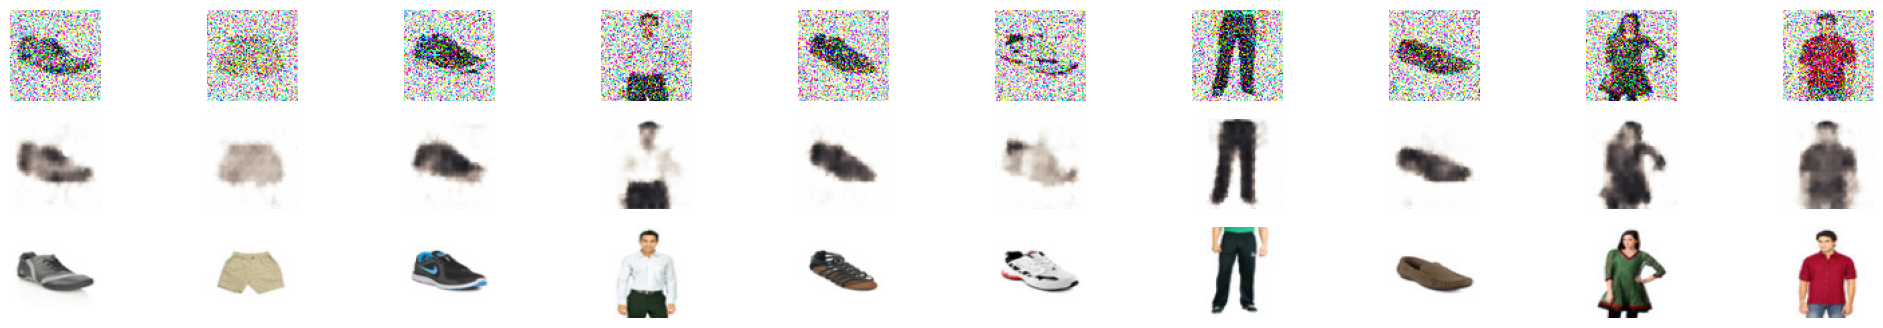

In [17]:
# 画图
fig, axes = plt.subplots(3, 10, figsize=(25, 4))
for imgs, row in zip([noise_imgs, outputs, original_imgs], axes):
    for img, ax in zip(imgs, row):
        ax.imshow(img)
        ax.axis('off')
plt.show()

In [19]:
image_names = os.listdir("/root/datasets/imagedata/dataset")
print(image_names)

['5702.jpg', '1570.jpg', '21257.jpg', '15373.jpg', '18507.jpg', '3098.jpg', '8638.jpg', '3473.jpg', '5866.jpg', '17751.jpg', '17236.jpg', '17685.jpg', '14903.jpg', '3119.jpg', '1451.jpg', '18192.jpg', '16293.jpg', '1550.jpg', '13295.jpg', '17135.jpg', '5265.jpg', '9040.jpg', '22543.jpg', '10970.jpg', '14281.jpg', '13292.jpg', '22965.jpg', '7971.jpg', '6605.jpg', '7318.jpg', '22038.jpg', '23072.jpg', '14309.jpg', '21846.jpg', '19427.jpg', '5267.jpg', '19149.jpg', '17784.jpg', '13066.jpg', '19977.jpg', '7491.jpg', '6418.jpg', '18689.jpg', '1779.jpg', '484.jpg', '16538.jpg', '13276.jpg', '20930.jpg', '6602.jpg', '24631.jpg', '14925.jpg', '9080.jpg', '11617.jpg', '6650.jpg', '14097.jpg', '14714.jpg', '2911.jpg', '8135.jpg', '2525.jpg', '9454.jpg', '11899.jpg', '8629.jpg', '11952.jpg', '17661.jpg', '11530.jpg', '75.jpg', '1381.jpg', '15550.jpg', '24829.jpg', '10053.jpg', '11122.jpg', '10297.jpg', '11737.jpg', '15.jpg', '20311.jpg', '17559.jpg', '2085.jpg', '12175.jpg', '13153.jpg', '16102.j

In [20]:
import re

In [21]:
a = re.split(r'([0-9]+)', "img01torch2tensor100.jpg")
b = re.split(r'([0-9]+)', "img01torch2tensor2.jpg")
print(a)
print(b)

['img', '01', 'torch', '2', 'tensor', '100', '.jpg']
['img', '01', 'torch', '2', 'tensor', '2', '.jpg']


In [22]:
print(a < b)

True


In [23]:
convert = lambda text: int(text) if text.isdigit() else text.lower()
a = [convert(x) for x in a]
b = [convert(x) for x in b]
print(a)
print(b)

['img', 1, 'torch', 2, 'tensor', 100, '.jpg']
['img', 1, 'torch', 2, 'tensor', 2, '.jpg']


In [24]:
print(a < b)

False
